In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
# from pyod.models.iforest import IForest
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import auc

In [2]:
def find_best_percent(result, granularity_all=1000):
    """
    find threshold
    :param result: sorted result
    :param granularity_all: granularity_all
    """
    max_percent = 0
    best_n = 1
    print("threshold tuning start:")
    for n in tqdm(range(1, 100)):
        head_n = n / granularity_all
        data_length = max(round(len(result) * head_n), 1)
        count_dist = count_entries(result.loc[:data_length - 1], 'label')
        try:
            percent = count_dist['1'] / (count_dist['0'] + count_dist['1'])
        except KeyError:
            print("can't find n%,take 1%")
            percent = 0.01
        if percent > max_percent:
            max_percent = percent
            best_n = n
    print("top %d / %s is the highest, %s" % (granularity_all, best_n, max_percent))
    return best_n, max_percent, granularity_all

def count_entries(df, col_name):
    """
    count
    """
    count_dist = {'0': 0, '1': 0}
    col = df[col_name]
    for entry in col:
        if str(int(entry)) in count_dist.keys():
            count_dist[str(int(entry))] = count_dist[str(int(entry))] + 1
        else:
            count_dist[str(int(entry))] = 1
    return count_dist

def find_best_result(threshold_n, result, dataframe_std):
    """
    find_best_result
    :param threshold_n: threshold
    :param result: sorted result
    :param dataframe_std: label
    """
    best_result, best_h, best_re, best_fa, best_f1, best_precision = None, 0, 0, 0, 0, 0
    best_auroc = 0
    for h in tqdm(range(50, 1000, 50)):
        train_result = charge_to_car(threshold_n, result, head_n=h)
        f1, recall, false_rate, precision, accuracy, auroc = evaluation(dataframe_std, train_result)
        if auroc >= best_auroc:
            best_f1 = f1
            best_h = h
            best_re = recall
            best_fa = false_rate
            best_result = train_result
            best_auroc = auroc
    return best_result, best_h, best_re, best_fa, best_f1, best_auroc

def charge_to_car(threshold_n, rec_result, head_n=92):
    """
    mapping from charge to car
    :param threshold_n: threshold
    :param rec_result: sorted result
    :param head_n: top %n
    :param gran: granularity
    """
    gran = 1000
    result = []
    for grp in rec_result.groupby('car'):
        temp = grp[1].values[:, -1].astype(float)
        idx = max(round(head_n / gran * len(temp)), 1)
        error = np.mean(temp[:idx])
        result.append([grp[0], int(error > threshold_n), error, threshold_n])
    return pd.DataFrame(result, columns=['car', 'predict', 'error', 'threshold_n'])

def evaluation(dataframe_std, dataframe):
    """
    calculated statistics
    :param dataframe_std:
    :param dataframe:
    :return:
    """

    # calculate auroc
#     print(dataframe) # error car
    _label = []
    for each_car in dataframe['car']:
        if int(each_car) in ind_car_num_list:
            _label.append(0)
        if int(each_car) in ood_car_num_list:
            _label.append(1)

    fpr, tpr, thresholds = metrics.roc_curve(_label, list(dataframe['error']), pos_label=1)
    auroc = auc(fpr, tpr)


    data = pd.merge(dataframe_std, dataframe, on='car')
    cm = confusion_matrix(data['label'].astype(int), data['predict'].astype(int))
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0
    false_rate = fp / (tn + fp) if tn + fp != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if tp + tn + fp + fn != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0
    return f1, recall, false_rate, precision, accuracy, auroc

(450034,) (450034,) (238521,) (238521,) (238521, 1)
450034
238521
(450034,)
(238521,)
(450034, 3)
(238521, 3)
[[  0.           7.         556.30600047]
 [  0.           7.         465.05719271]
 [  0.           7.         535.57888305]
 [  0.           7.         308.65361707]
 [  0.           7.         535.6921988 ]]
(688555, 3)
(475481, 3) (213074, 3)


 17%|█▋        | 17/99 [00:00<00:00, 156.06it/s]

找出最大的前n%的比例 阈值调参开始:


  0%|          | 1/200 [00:00<00:32,  6.20it/s]

前1000分之1个数的比例最高，为0.44842105263157894
threshold_n 748.3464011252071
训练集自检调参开始,flag is rec_error


100%|██████████| 200/200 [00:31<00:00,  6.23it/s]


dataframe_std is  302 &&   dataframe is  211
最好的1000分之51:
检出率: 0.6
误报率: 0.024875621890547265
F1: 0.5714285714285713


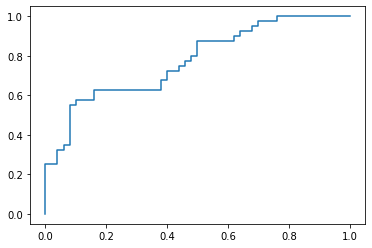

0.773
(442717,) (442717,) (245838,) (245838,) (245838, 1)
442717
245838
(442717,)
(245838,)
(442717, 3)
(245838, 3)
[[  0.           2.          62.84587454]
 [  0.           2.         191.72063161]
 [  0.           2.         113.96865448]
 [  0.           2.         215.53144965]
 [  0.           2.         224.05053891]]
(688555, 3)
(468313, 3) (220242, 3)


 17%|█▋        | 17/99 [00:00<00:00, 154.08it/s]

找出最大的前n%的比例 阈值调参开始:


  0%|          | 1/200 [00:00<00:33,  6.02it/s]

前1000分之3个数的比例最高，为0.5814946619217082
threshold_n 673.7769784238153
训练集自检调参开始,flag is rec_error


100%|██████████| 200/200 [00:31<00:00,  6.28it/s]


dataframe_std is  302 &&   dataframe is  211
最好的1000分之64:
检出率: 0.6
误报率: 0.04477611940298507
F1: 0.48


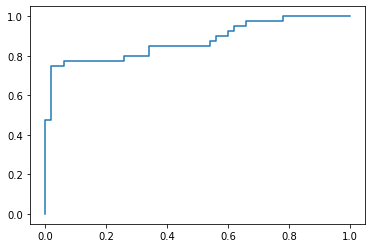

0.8755
(456879,) (456879,) (231676,) (231676,) (231676, 1)
456879
231676
(456879,)
(231676,)
(456879, 3)
(231676, 3)
[[  0.           2.          72.80060363]
 [  0.           2.         200.77237661]
 [  0.           2.          81.11991744]
 [  0.           2.         240.91280919]
 [  0.           2.         253.10535494]]
(688555, 3)
(506214, 3) (182341, 3)


 17%|█▋        | 17/99 [00:00<00:00, 162.30it/s]

找出最大的前n%的比例 阈值调参开始:


  0%|          | 1/200 [00:00<00:34,  5.80it/s]

前1000分之3个数的比例最高，为0.39433838051349573
threshold_n 673.8131732104998
训练集自检调参开始,flag is rec_error


100%|██████████| 200/200 [00:32<00:00,  6.19it/s]


dataframe_std is  302 &&   dataframe is  211
最好的1000分之61:
检出率: 0.7
误报率: 0.04975124378109453
F1: 0.5185185185185185


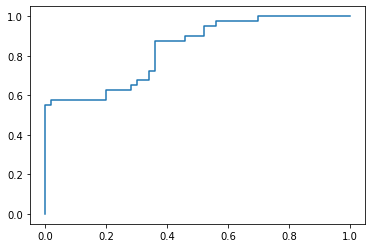

0.835
(441057,) (441057,) (247498,) (247498,) (247498, 1)
441057
247498
(441057,)
(247498,)
(441057, 3)
(247498, 3)
[[  0.           2.          77.8080462 ]
 [  0.           2.         190.58811184]
 [  0.           2.          82.79179143]
 [  0.           2.         242.22508469]
 [  0.           2.         259.94758521]]
(688555, 3)
(461119, 3) (227436, 3)


 18%|█▊        | 18/99 [00:00<00:00, 167.32it/s]

找出最大的前n%的比例 阈值调参开始:


  0%|          | 1/200 [00:00<00:33,  5.94it/s]

前1000分之1个数的比例最高，为0.6290672451193059
threshold_n 752.3882463248698
训练集自检调参开始,flag is rec_error


100%|██████████| 200/200 [00:30<00:00,  6.69it/s]


dataframe_std is  302 &&   dataframe is  211
最好的1000分之165:
检出率: 0.4
误报率: 0.004975124378109453
F1: 0.5333333333333333


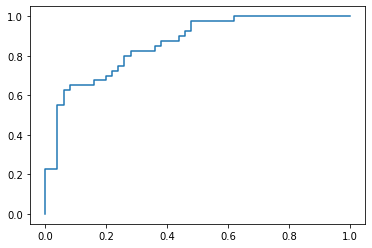

0.8594999999999999
(447685,) (447685,) (240870,) (240870,) (240870, 1)
447685
240870
(447685,)
(240870,)
(447685, 3)
(240870, 3)
[[  0.           2.          62.69390045]
 [  0.           2.         196.1393564 ]
 [  0.           2.         110.06274975]
 [  0.           2.         246.94261561]
 [  0.           2.         265.61260239]]
(688555, 3)
(456207, 3) (232348, 3)


 11%|█         | 11/99 [00:00<00:00, 99.87it/s]

找出最大的前n%的比例 阈值调参开始:


  0%|          | 1/200 [00:00<00:32,  6.18it/s]

前1000分之1个数的比例最高，为0.5745614035087719
threshold_n 755.3726557053928
训练集自检调参开始,flag is rec_error


100%|██████████| 200/200 [00:31<00:00,  6.68it/s]


dataframe_std is  302 &&   dataframe is  210
最好的1000分之79:
检出率: 0.5
误报率: 0.01
F1: 0.588235294117647


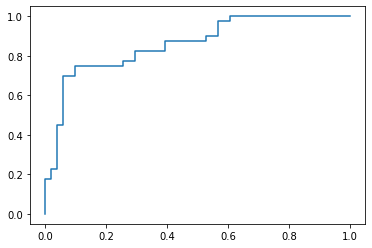

0.8588235294117648


In [4]:
AUC_list = []

prefix = ''

for fold_num in range(5):


    # change to your corresponding dir
    y_train_pred = np.load(f'../AE_and_SVDD/traditional_save/{prefix}_auto_encoder_use_ind_only_fold%d_y_train_pred.npy' % fold_num)
    y_train_scores = np.load(f'../AE_and_SVDD/traditional_save/{prefix}_auto_encoder_use_ind_only_fold%d_y_train_scores.npy' % fold_num)
    y_test_pred = np.load(f'../AE_and_SVDD/traditional_save/{prefix}_auto_encoder_use_ind_only_fold%d_y_test_pred.npy' % fold_num)
    y_test_scores = np.load(f'../AE_and_SVDD/traditional_save/{prefix}_auto_encoder_use_ind_only_fold%d_y_test_scores.npy' % fold_num)
    y_test = np.load(f'../AE_and_SVDD/traditional_save/{prefix}_auto_encoder_use_ind_only_fold%d_y_test.npy' % fold_num)

    print(y_train_pred.shape, y_train_scores.shape, y_test_pred.shape, y_test_scores.shape, y_test.shape)

    # replace the following two car number lists
    ind_ood_car_dict = np.load('../five_fold_utils/ind_odd_dict1.npz.npy', allow_pickle=True).item()
    ind_car_num_list = ind_ood_car_dict['ind_sorted']
    ood_car_num_list = ind_ood_car_dict['ood_sorted']
    
    
    #
    car_number_train = ind_car_num_list[:int(fold_num * len(ind_car_num_list) / 5)] + ind_car_num_list[int((fold_num + 1) * len(ind_car_num_list) / 5):]
    car_number_test = ind_car_num_list[int(fold_num * len(ind_car_num_list) / 5):int((fold_num + 1) * len(ind_car_num_list) / 5)] + ood_car_num_list

    # build 3 column csv file
    all_car_dict = np.load('../five_fold_utils/all_car_dict.npz.npy', allow_pickle=True).item()

    car_train = []
    for each_num in car_number_train:
        for each_pkl in all_car_dict[each_num]:
            car_train.append(each_num)
    car_test = []
    for each_num in car_number_test:
        for each_pkl in all_car_dict[each_num]:
            car_test.append(each_num)
    print(len(car_train))
    print(len(car_test))
    car_train = np.array(car_train)
    car_test = np.array(car_test)

    print(y_train_scores.shape)
    print(y_test_scores.shape)

    car_label_train = []
    car_label_test = []

    for each in car_train:
        if each in ind_car_num_list:
            car_label_train.append(0)
        if each in ood_car_num_list:
            car_label_train.append(1)
    for each in car_test:
        if each in ind_car_num_list:
            car_label_test.append(0)
        if each in ood_car_num_list:
            car_label_test.append(1)
    car_label_train = np.array(car_label_train)
    car_label_test = np.array(car_label_test)

    data_train = np.vstack((car_label_train, car_train, y_train_scores)).T
    data_test = np.vstack((car_label_test, car_test, y_test_scores)).T

    data = np.vstack((data_train, data_test))

    print(data_train.shape)
    print(data_test.shape)
    print(data_train[:5, ])
    print(data.shape)

    validation_car_number = ind_car_num_list[:int(fold_num * len(ind_car_num_list) / 5)] + ind_car_num_list[int((fold_num + 1) * len(ind_car_num_list) / 5):] + ood_car_num_list[int(fold_num * len(ood_car_num_list) / 5):int((fold_num + 1) * len(ood_car_num_list) / 5)]
    test_car_number = ind_car_num_list[int(fold_num * len(ind_car_num_list) / 5):int((fold_num + 1) * len(ind_car_num_list) / 5)] + ood_car_num_list[:int(fold_num * len(ood_car_num_list) / 5)] + ood_car_num_list[int((fold_num + 1) * len(ood_car_num_list) / 5):]


    validation_data = []
    test_data = []

    for each_line in data:
        if each_line[1] in validation_car_number:
            validation_data.append(each_line)
        else:
            test_data.append(each_line)

    validation_data = np.array(validation_data)
    test_data = np.array(test_data)
    print(validation_data.shape, test_data.shape)

    rec_sorted_index = np.argsort(-validation_data[:, 2].astype(float))
    res = [validation_data[i][[1, 0, 2]] for i in rec_sorted_index]
    result = pd.DataFrame(res, columns=['car', 'label', 'rec_error'])
    result['car'] = result['car'].astype("int").astype("str")
    best_n, max_percent, granularity = find_best_percent(result, granularity_all=1000)
    head_n = best_n / granularity
    data_length = round(len(result) * head_n)
    threshold_n = result['rec_error'].values[data_length - 1].astype(float)
    print("threshold_n", threshold_n)
    print("trainset start,flag is", 'rec_error')
    #
    dataframe_std1 = pd.read_csv(os.path.join('../data/battery_brand1/label', "train_label.csv"), dtype=object)
    dataframe_std2 = pd.read_csv(os.path.join('../data/battery_brand1/label', "test_label.csv"), dtype=object)
    dataframe_std3 = pd.read_csv(os.path.join('../data/battery_brand2/label', "train_label.csv"), dtype=object)
    dataframe_std4 = pd.read_csv(os.path.join('../data/battery_brand2/label', "test_label.csv"), dtype=object)
    dataframe_std5 = pd.read_csv(os.path.join('../data/battery_brand4/label', "all_label.csv"), dtype=object)
    dataframe_std = pd.concat([dataframe_std1, dataframe_std2, dataframe_std3, dataframe_std4, dataframe_std5], axis=0,ignore_index=True)
    assert max(dataframe_std['car'].astype("int"))>300
    assert 201 in dataframe_std['car'].astype("int")
    best_result, best_h, best_re, best_fa, best_f1, best_auroc = find_best_result(threshold_n, result, dataframe_std)
    # best_result.to_csv(os.path.join(self.args.result_path, "train_res.csv")),
    if dataframe_std.shape[0] == best_result.shape[0]:
        pass
    else:
        print('dataframe_std is ', dataframe_std.shape[0], '&&   dataframe is ', best_result.shape[0])
    print("best 1000 / %d:" % best_h)
    print("re:", best_re)
    print("fa:", best_fa)
    print("F1:", best_f1)
    rec_sorted_index = np.argsort(-test_data[:, 2].astype(float))
    res = [test_data[i][[1, 0, 2]] for i in rec_sorted_index]
    result = pd.DataFrame(res, columns=['car', 'label', 'rec_error'])
    result['car'] = result['car'].astype("int").astype("str")
    # result.to_csv(os.path.join(self.args.result_path, "test_segment_scores.csv"))
    test_result = charge_to_car(threshold_n, result, head_n=best_h)

    _score = list(test_result['error'])
    _label = []
    for each_car in test_result['car']:
        if int(each_car) in ind_car_num_list:
            _label.append(0)
        if int(each_car) in ood_car_num_list:
            _label.append(1)

    fpr, tpr, thresholds = metrics.roc_curve(_label, _score, pos_label=1)

    np.save('../AE_and_SVDD/traditional_save/robust_all_score_fold%d.npy' % fold_num, _score)
    np.save('../AE_and_SVDD/traditional_save/robust_labels_fold%d.npy' % fold_num, _label)

    # print(_label, _score)
    plt.plot(fpr, tpr)
    plt.show()
    AUC = auc(fpr, tpr)
    print(AUC)
    AUC_list.append(AUC)



In [5]:
print(AUC_list)
print(np.mean(AUC_list))

[0.773, 0.8755, 0.835, 0.8594999999999999, 0.8588235294117648]
0.840364705882353
